In [1]:
from src.hierarchical_model import nc_hierarchical_model_general, hierarchical_logistic_model
from src.invariance_tests import invariance_tests
from jax import random
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns

np.random.seed(42)
sns.set_style("darkgrid")


In [2]:
# Load the dataset directly from the Rdatasets repository
url = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/CollegeDistance.csv"
df = pd.read_csv(url)

# Display the first few rows
print(df.head())

   rownames  gender ethnicity      score fcollege mcollege home urban  unemp  \
0         1    male     other  39.150002      yes       no  yes   yes    6.2   
1         2  female     other  48.869999       no       no  yes   yes    6.2   
2         3    male     other  48.740002       no       no  yes   yes    6.2   
3         4    male      afam  40.400002       no       no  yes   yes    6.2   
4         5  female     other  40.480000       no       no   no   yes    5.6   

   wage  distance  tuition  education income region  
0  8.09       0.2  0.88915         12   high  other  
1  8.09       0.2  0.88915         12    low  other  
2  8.09       0.2  0.88915         12    low  other  
3  8.09       0.2  0.88915         12    low  other  
4  8.09       0.4  0.88915         13    low  other  


In [3]:
# Drop the unnecessary index column
df = df.drop(columns=["rownames"])

# Summary of the dataset
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4739 entries, 0 to 4738
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gender     4739 non-null   object 
 1   ethnicity  4739 non-null   object 
 2   score      4739 non-null   float64
 3   fcollege   4739 non-null   object 
 4   mcollege   4739 non-null   object 
 5   home       4739 non-null   object 
 6   urban      4739 non-null   object 
 7   unemp      4739 non-null   float64
 8   wage       4739 non-null   float64
 9   distance   4739 non-null   float64
 10  tuition    4739 non-null   float64
 11  education  4739 non-null   int64  
 12  income     4739 non-null   object 
 13  region     4739 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 518.5+ KB


,score,unemp,wage,distance,tuition,education
count,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000
mean,50.889029,7.597215,9.500506,1.802870,0.814608,13.807765
std,8.701910,2.763581,1.343067,2.297128,0.339504,1.789107
min,28.950001,1.400000,6.590000,0.000000,0.257510,12.000000
25%,43.924999,5.900000,8.850000,0.400000,0.484990,12.000000
50%,51.189999,7.100000,9.680000,1.000000,0.824480,13.000000
75%,57.769999,8.900000,10.150000,2.500000,1.127020,16.000000
max,72.809998,24.900000,12.960000,20.000000,1.404160,18.000000


In [4]:
# Ensure the target variable `education` is binary
df['education'] = (df['education'] > 16).astype(int)

df["environment"] = np.where(df["distance"] <= (df['distance'].median()).astype(int), 0, 1)
e = df['environment'].values
E = len(df['environment'].unique())

scaler = StandardScaler()
continuous_cols = ['score', 'tuition', 'unemp', 'wage', 'distance']
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

# Convert categorical variables to dummies
df = pd.get_dummies(
    df,
    columns=['gender', 'ethnicity', 'fcollege', 'mcollege', 'home', 'urban', 'income', 'region'],
    drop_first=True
)

In [5]:
X_cols = [col for col in df.columns if col not in ['education']]
X = df[X_cols].values
Y = df['education'].values

# Convert to JAX arrays
X_jax = jnp.array(X, dtype=jnp.float32)
Y_jax = jnp.array(Y, dtype=jnp.int32)  # Must be integers for Bernoulli
e_jax = jnp.array(e, dtype=jnp.int32)

sample: 100%|██████████| 4000/4000 [01:28<00:00, 45.25it/s, 255 steps of size 2.37e-02. acc. prob=0.88]


--------- Predictor 0 ---------
--------- Predictor score ---------
beta_score_env_0 HDI: [0.7748, 1.1309]
beta_score_env_0 ROPE: [-0.0091, 0.0091]


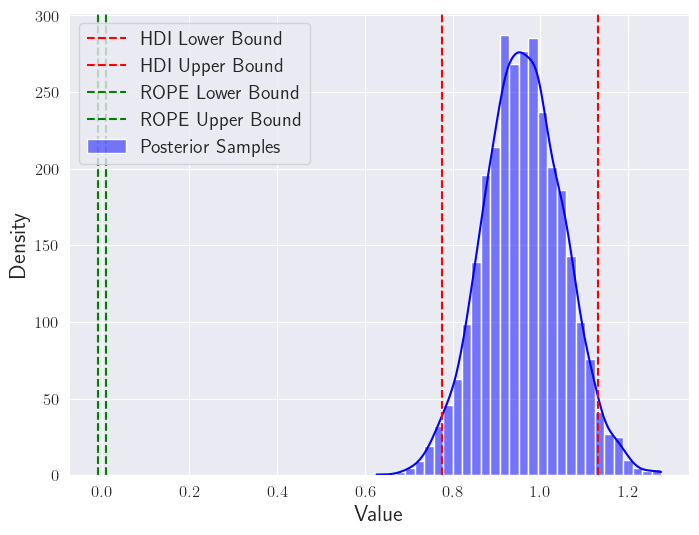

beta_score_env_1 HDI: [0.7550, 1.1894]
beta_score_env_1 ROPE: [-0.0110, 0.0110]


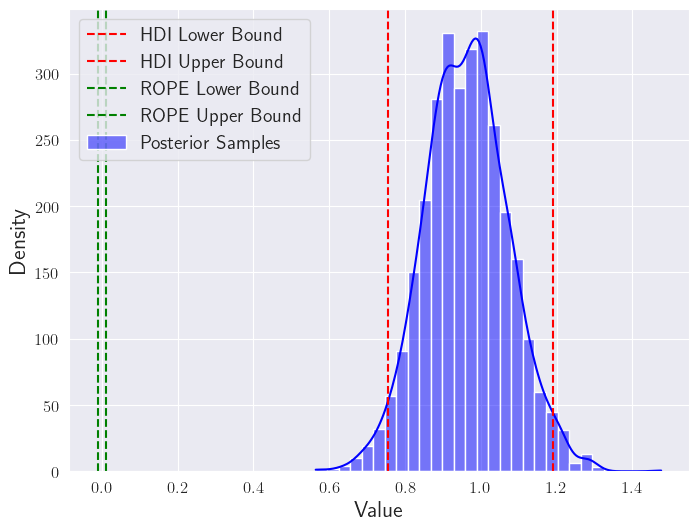

mu_score HDI: [-0.0194, 1.4168]
mu_score ROPE: [-0.3347, 0.3347]


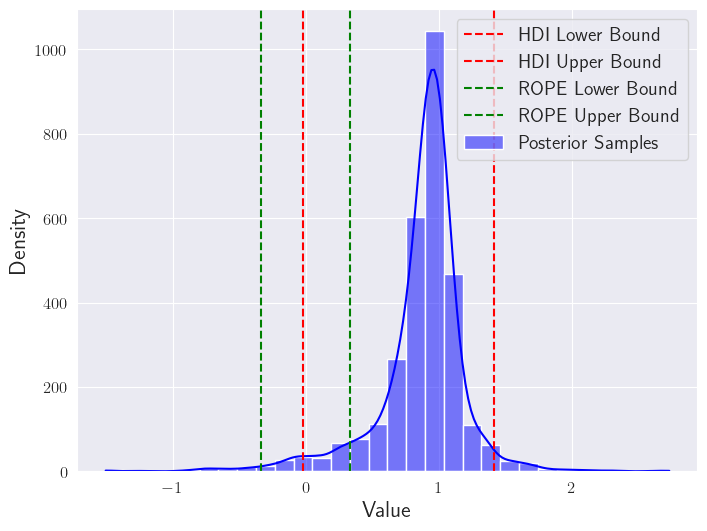

Local tests: ['Rejected', 'Rejected']
Global test for mu: Undecided
Pooling Factor (normal): 1.0000
--------- Predictor 1 ---------
--------- Predictor unemp ---------
beta_unemp_env_0 HDI: [0.0354, 0.4151]
beta_unemp_env_0 ROPE: [-0.0098, 0.0098]


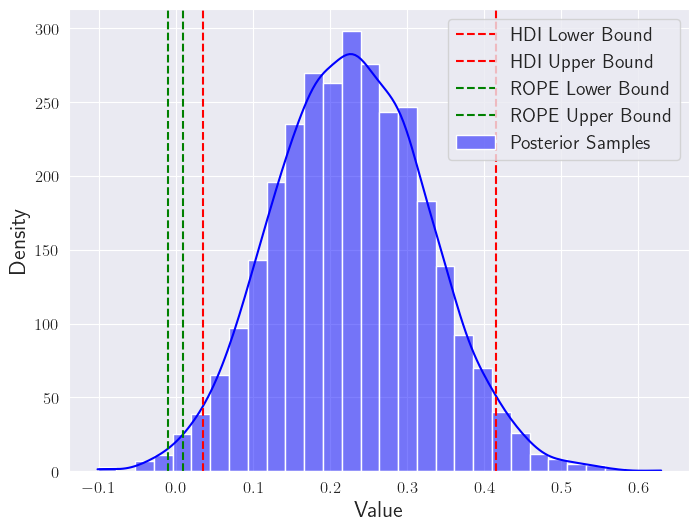

beta_unemp_env_1 HDI: [-0.0480, 0.3024]
beta_unemp_env_1 ROPE: [-0.0090, 0.0090]


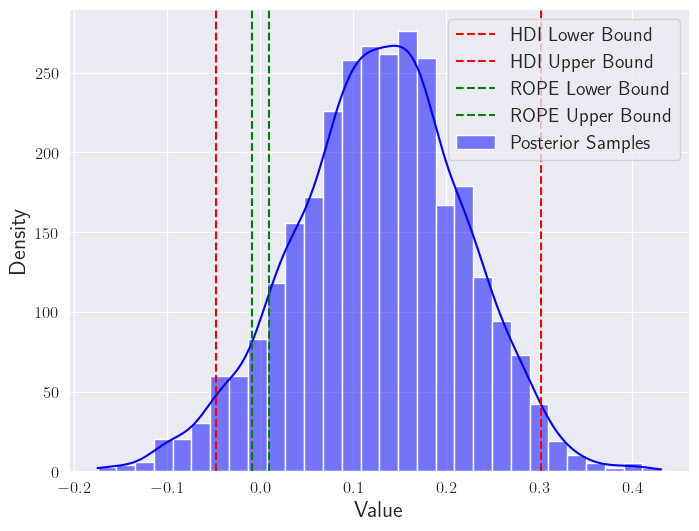

mu_unemp HDI: [-0.5195, 0.8282]
mu_unemp ROPE: [-0.3130, 0.3130]


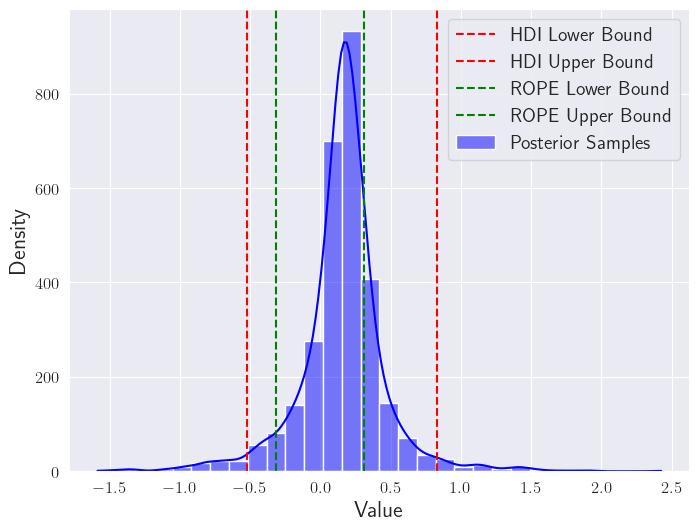

Local tests: ['Rejected', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9739
--------- Predictor 2 ---------
--------- Predictor wage ---------
beta_wage_env_0 HDI: [-0.1807, 0.1485]
beta_wage_env_0 ROPE: [-0.0084, 0.0084]


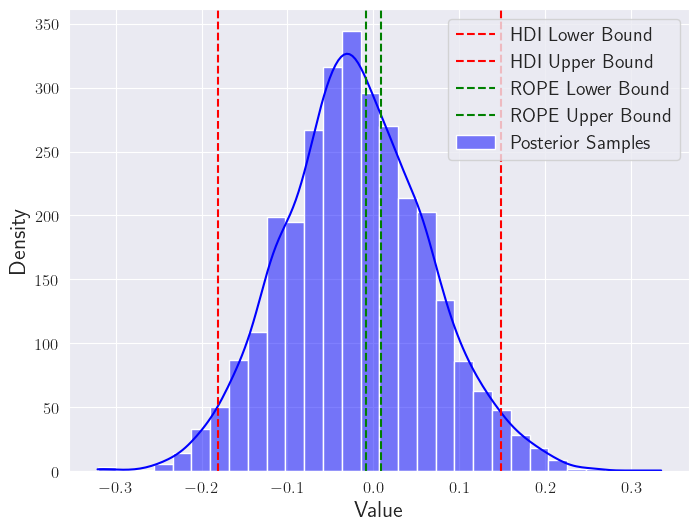

beta_wage_env_1 HDI: [-0.3262, 0.0640]
beta_wage_env_1 ROPE: [-0.0101, 0.0101]


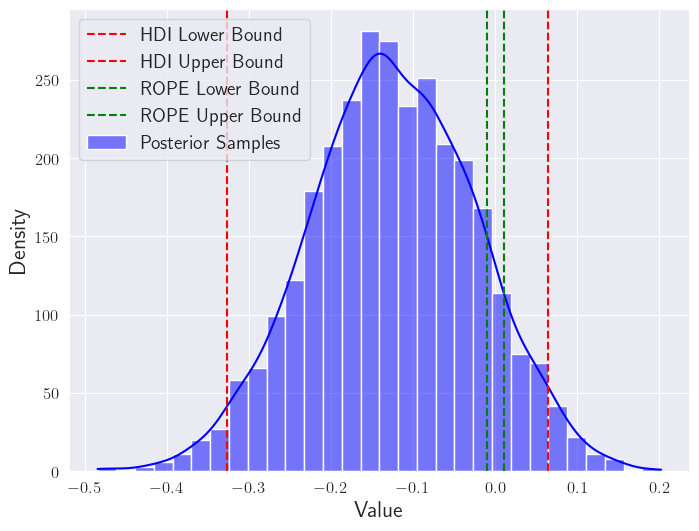

mu_wage HDI: [-0.6749, 0.7115]
mu_wage ROPE: [-0.3191, 0.3191]


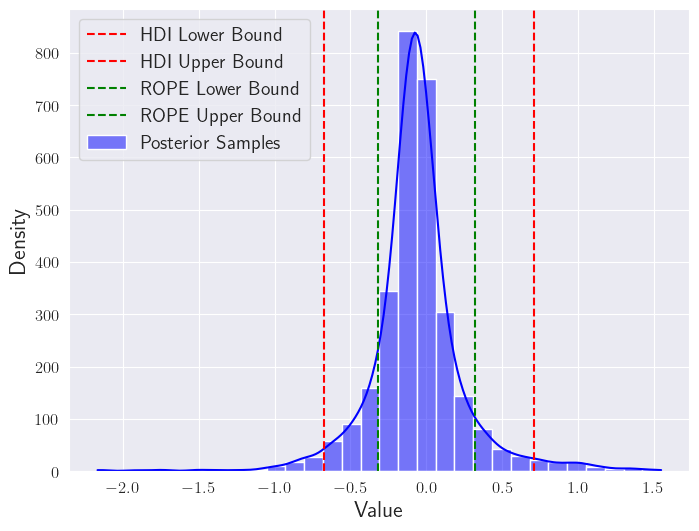

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9735
--------- Predictor 3 ---------
--------- Predictor distance ---------
beta_distance_env_0 HDI: [2.0312, 3.4221]
beta_distance_env_0 ROPE: [-0.0360, 0.0360]


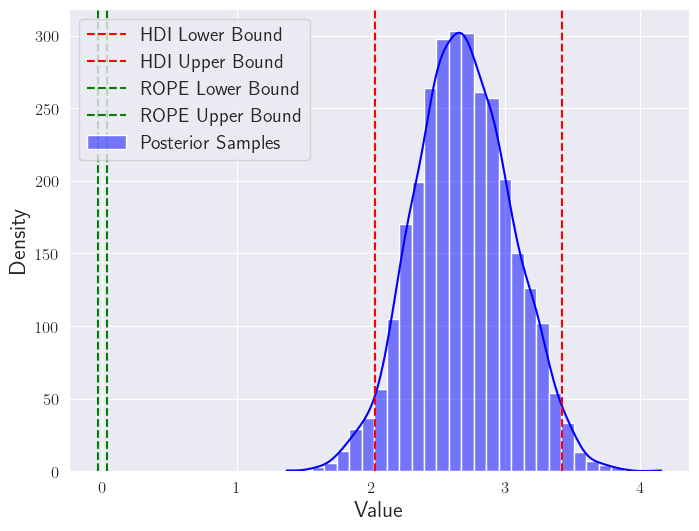

beta_distance_env_1 HDI: [-0.7182, -0.1962]
beta_distance_env_1 ROPE: [-0.0136, 0.0136]


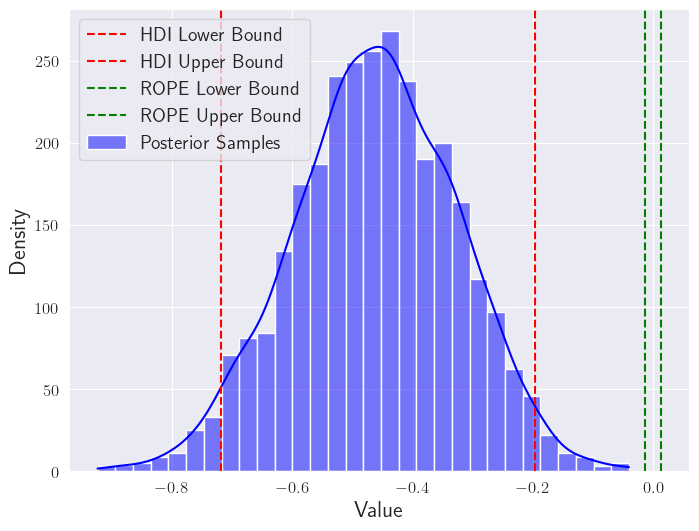

mu_distance HDI: [-1.3413, 2.0405]
mu_distance ROPE: [-0.8487, 0.8487]


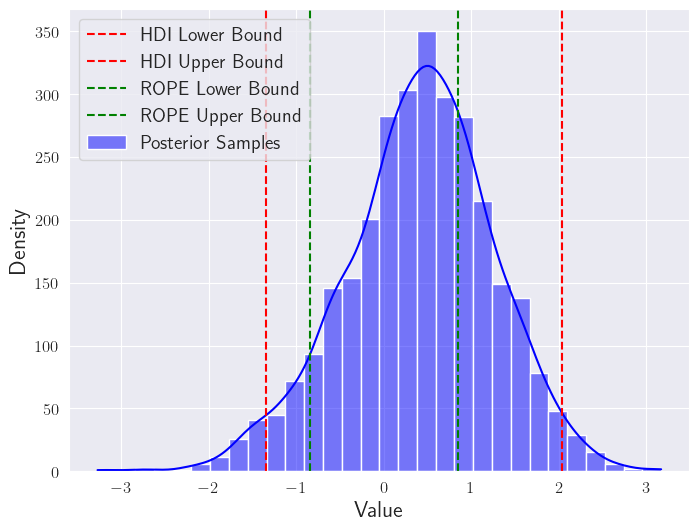

Local tests: ['Rejected', 'Rejected']
Global test for mu: Undecided
Pooling Factor (normal): 0.0000
--------- Predictor 4 ---------
--------- Predictor tuition ---------
beta_tuition_env_0 HDI: [-0.4437, -0.0429]
beta_tuition_env_0 ROPE: [-0.0102, 0.0102]


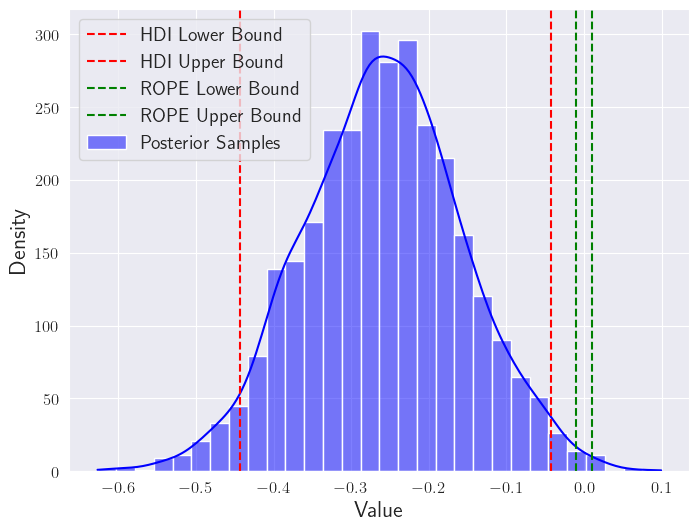

beta_tuition_env_1 HDI: [-0.4681, 0.0011]
beta_tuition_env_1 ROPE: [-0.0120, 0.0120]


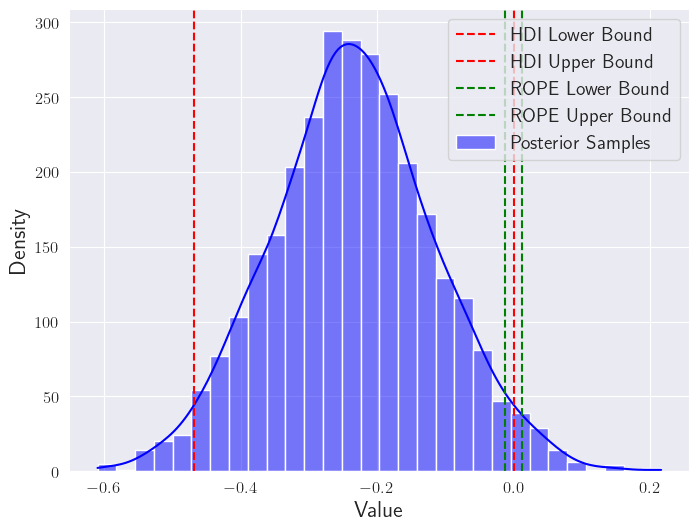

mu_tuition HDI: [-0.8628, 0.4159]
mu_tuition ROPE: [-0.3038, 0.3038]


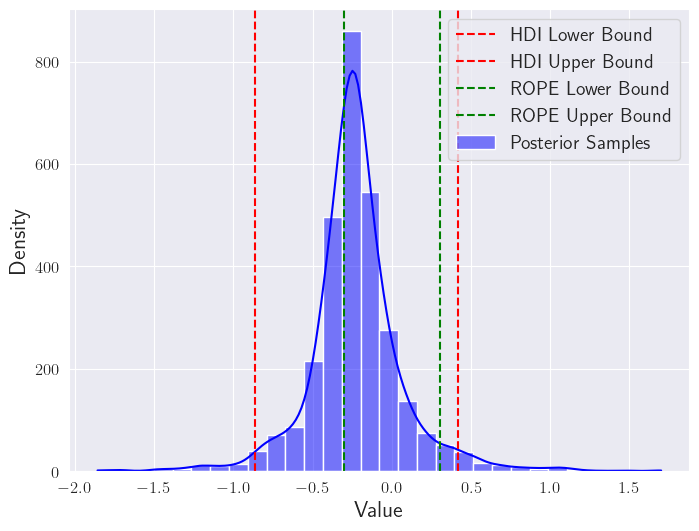

Local tests: ['Rejected', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9984
--------- Predictor 5 ---------
--------- Predictor environment ---------
beta_environment_env_0 HDI: [-5.4251, 6.0037]
beta_environment_env_0 ROPE: [-0.2874, 0.2874]


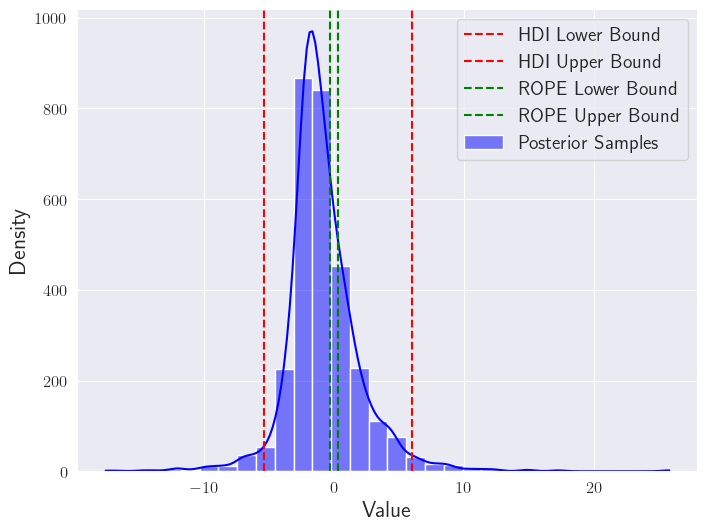

beta_environment_env_1 HDI: [-3.4028, -1.5224]
beta_environment_env_1 ROPE: [-0.0487, 0.0487]


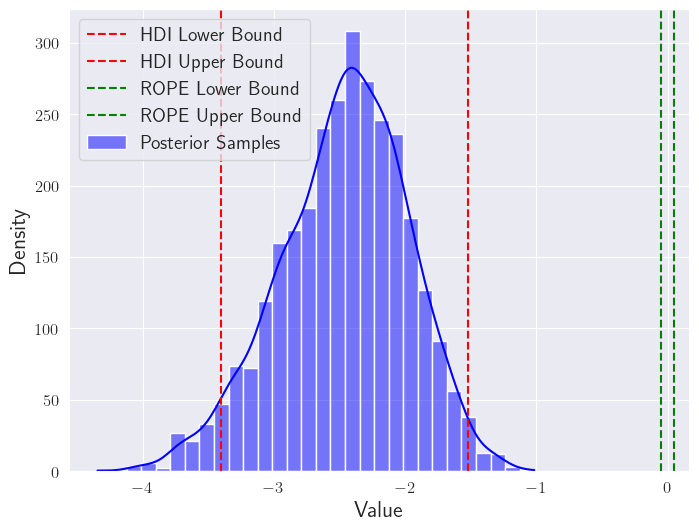

mu_environment HDI: [-2.7536, 1.1149]
mu_environment ROPE: [-1.0161, 1.0161]


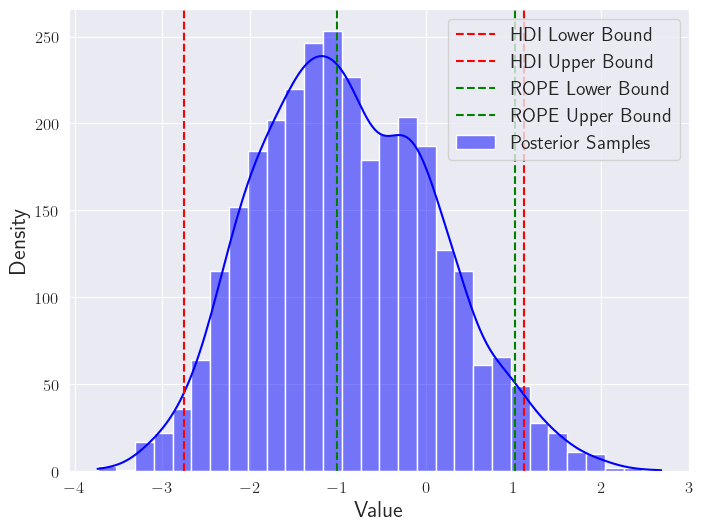

Local tests: ['Undecided', 'Rejected']
Global test for mu: Undecided
Pooling Factor (normal): 0.8435
--------- Predictor 6 ---------
--------- Predictor gender_male ---------
beta_gender_male_env_0 HDI: [-0.5718, 0.0096]
beta_gender_male_env_0 ROPE: [-0.0152, 0.0152]


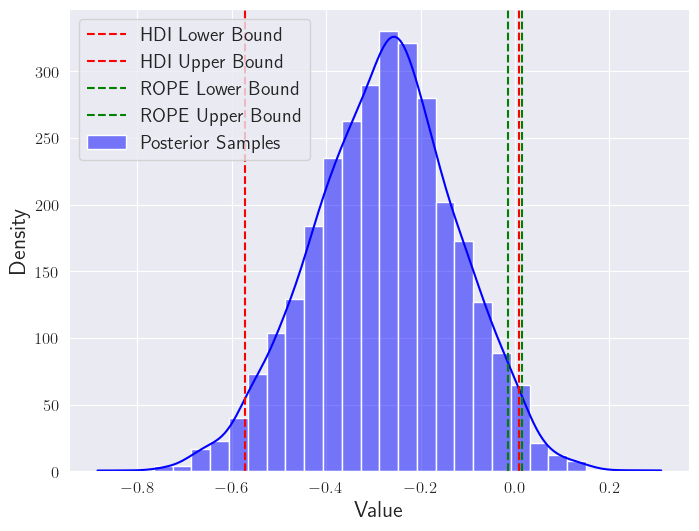

beta_gender_male_env_1 HDI: [-0.3405, 0.3990]
beta_gender_male_env_1 ROPE: [-0.0191, 0.0191]


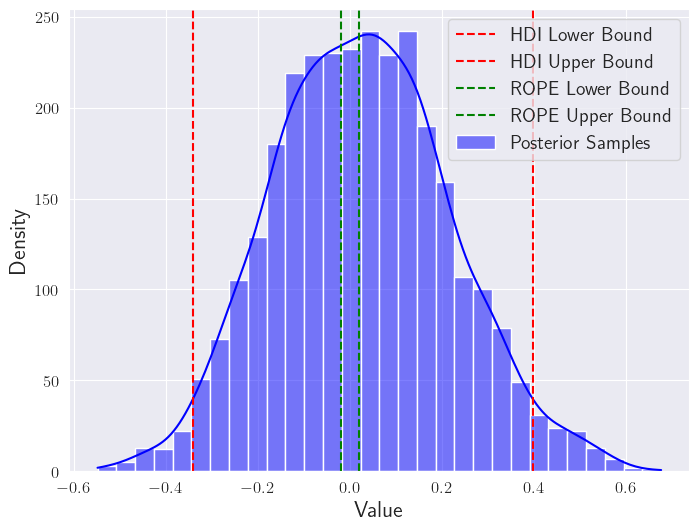

mu_gender_male HDI: [-1.0330, 0.7085]
mu_gender_male ROPE: [-0.4131, 0.4131]


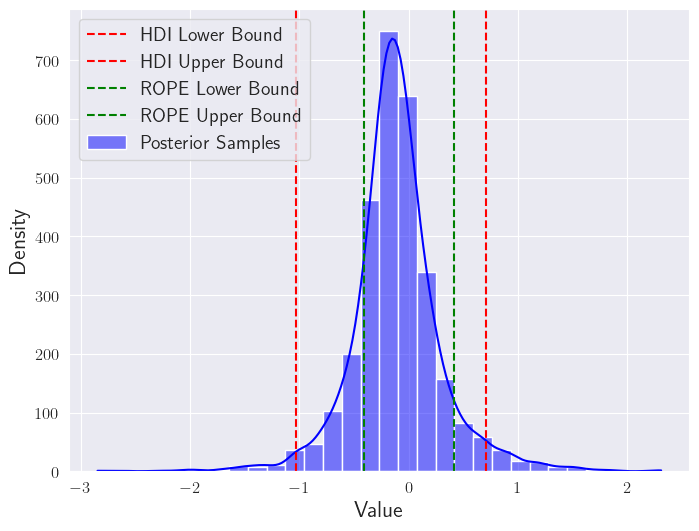

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.8720
--------- Predictor 7 ---------
--------- Predictor ethnicity_hispanic ---------
beta_ethnicity_hispanic_env_0 HDI: [-0.9280, 0.0460]
beta_ethnicity_hispanic_env_0 ROPE: [-0.0250, 0.0250]


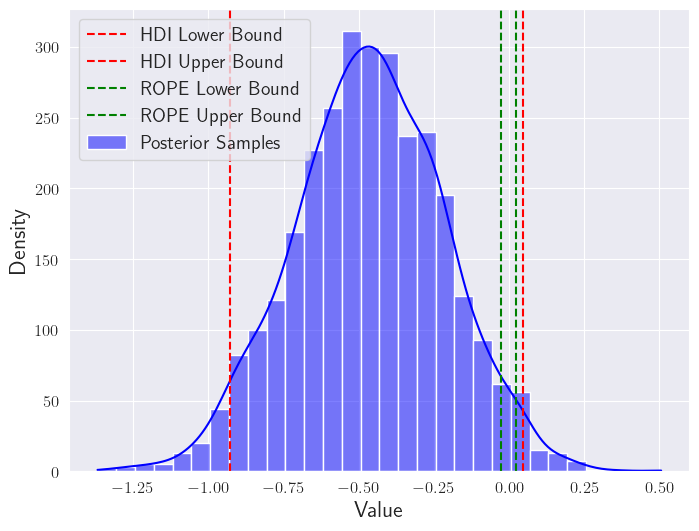

beta_ethnicity_hispanic_env_1 HDI: [-0.3429, 1.3862]
beta_ethnicity_hispanic_env_1 ROPE: [-0.0448, 0.0448]


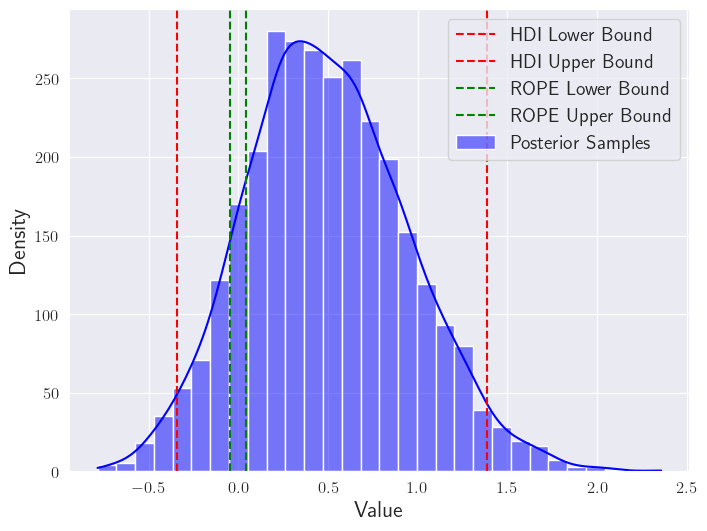

mu_ethnicity_hispanic HDI: [-1.1191, 1.2112]
mu_ethnicity_hispanic ROPE: [-0.5662, 0.5662]


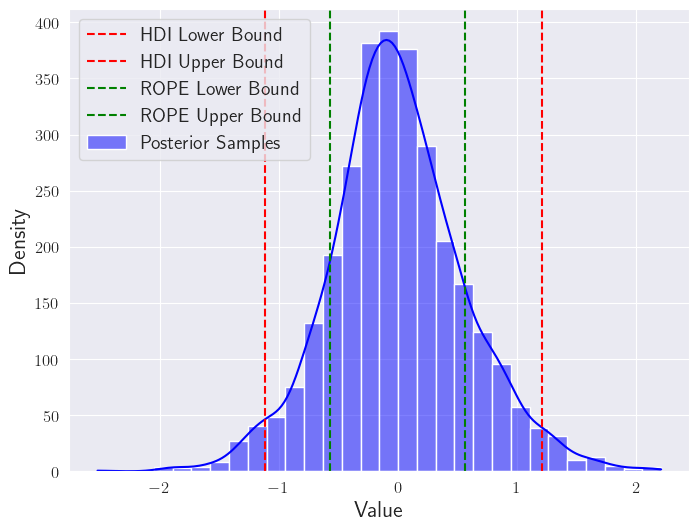

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.3697
--------- Predictor 8 ---------
--------- Predictor ethnicity_other ---------
beta_ethnicity_other_env_0 HDI: [-1.2007, -0.4582]
beta_ethnicity_other_env_0 ROPE: [-0.0190, 0.0190]


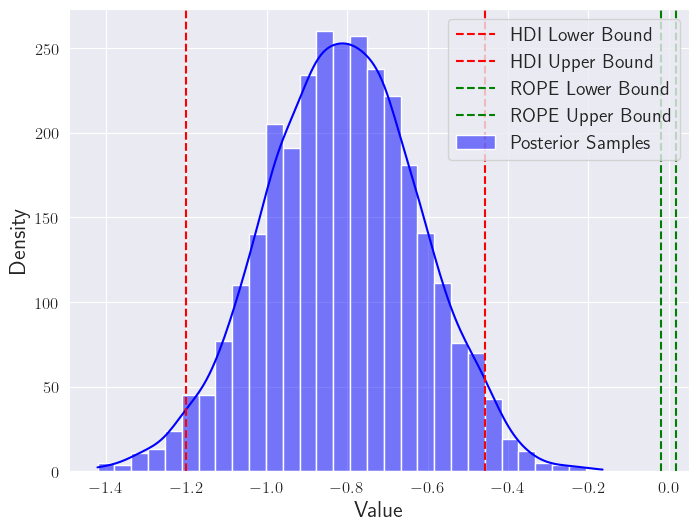

beta_ethnicity_other_env_1 HDI: [-1.1085, 0.3685]
beta_ethnicity_other_env_1 ROPE: [-0.0381, 0.0381]


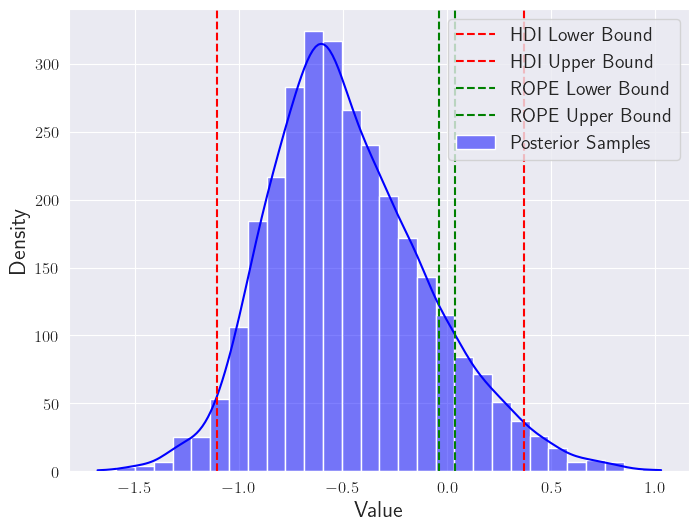

mu_ethnicity_other HDI: [-1.3554, 0.6164]
mu_ethnicity_other ROPE: [-0.4880, 0.4880]


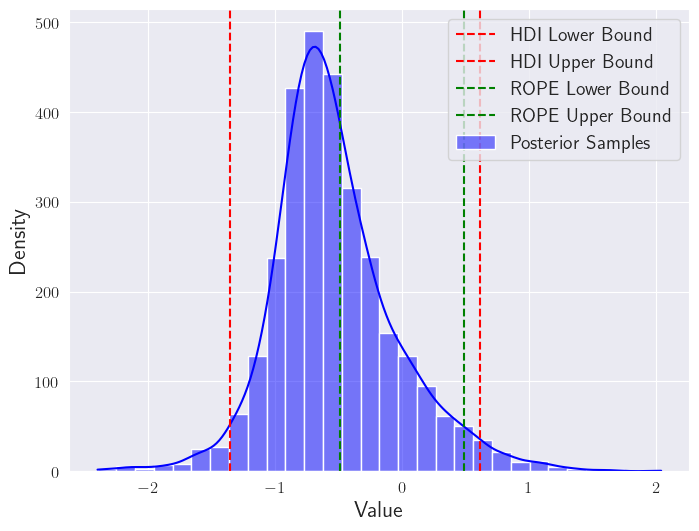

Local tests: ['Rejected', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.8808
--------- Predictor 9 ---------
--------- Predictor fcollege_yes ---------
beta_fcollege_yes_env_0 HDI: [0.0111, 0.6808]
beta_fcollege_yes_env_0 ROPE: [-0.0174, 0.0174]


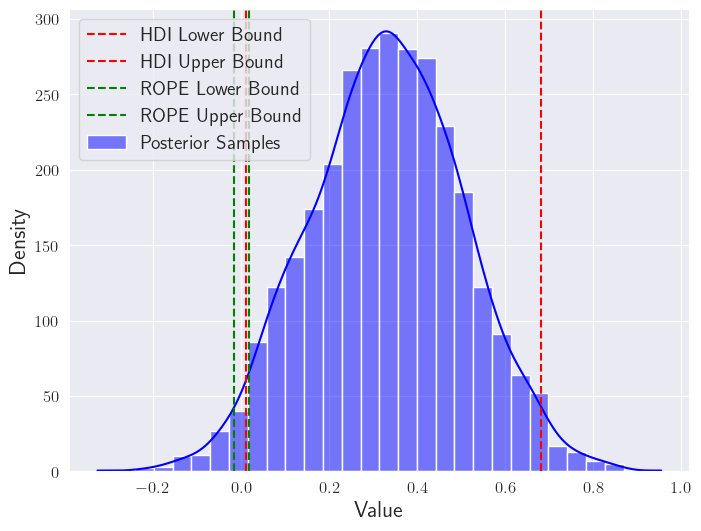

beta_fcollege_yes_env_1 HDI: [0.1315, 1.0252]
beta_fcollege_yes_env_1 ROPE: [-0.0228, 0.0228]


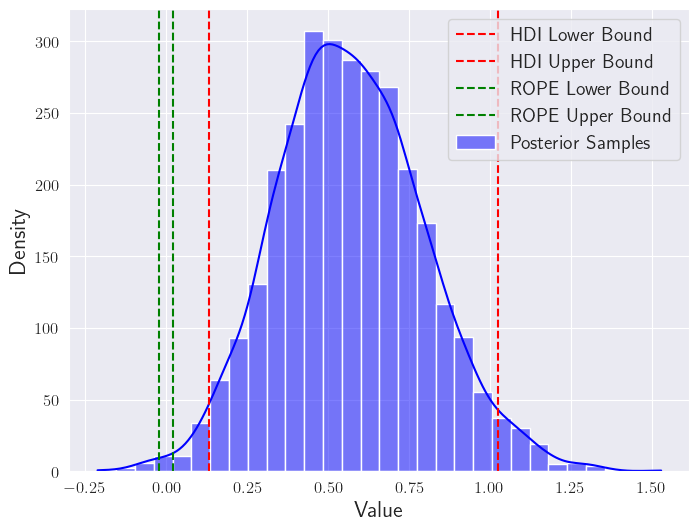

mu_fcollege_yes HDI: [-0.5376, 1.2048]
mu_fcollege_yes ROPE: [-0.4132, 0.4132]


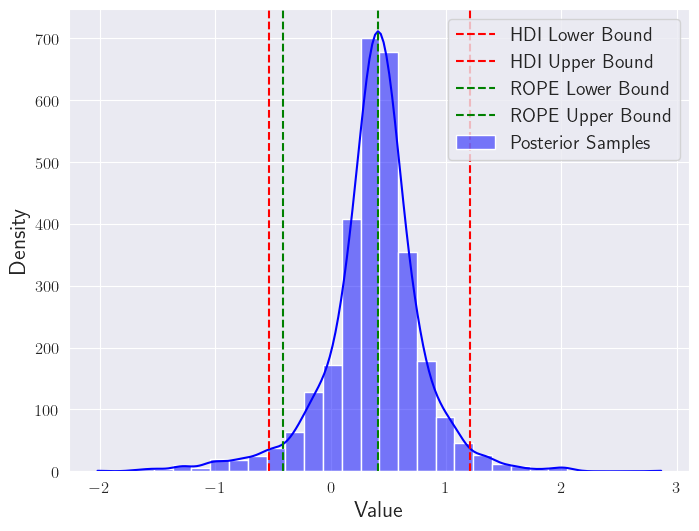

Local tests: ['Undecided', 'Rejected']
Global test for mu: Undecided
Pooling Factor (normal): 0.9192
--------- Predictor 10 ---------
--------- Predictor mcollege_yes ---------
beta_mcollege_yes_env_0 HDI: [-0.0809, 0.6184]
beta_mcollege_yes_env_0 ROPE: [-0.0183, 0.0183]


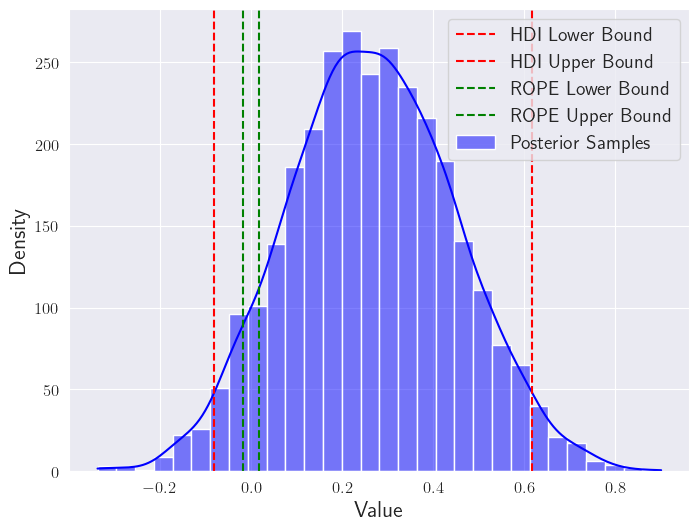

beta_mcollege_yes_env_1 HDI: [-0.5315, 0.4339]
beta_mcollege_yes_env_1 ROPE: [-0.0254, 0.0254]


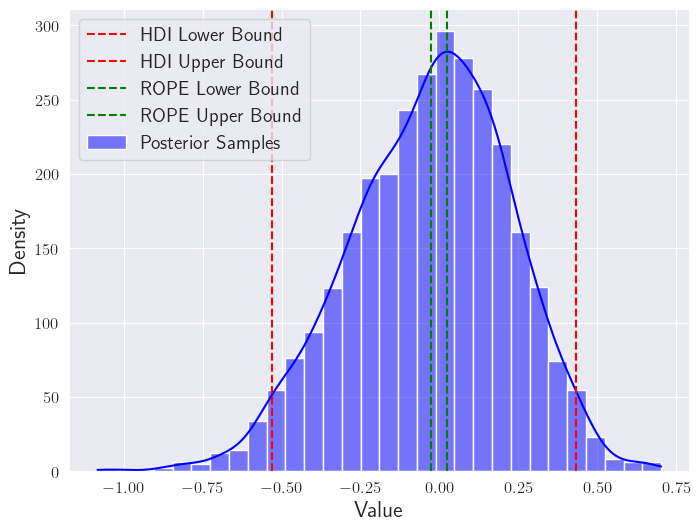

mu_mcollege_yes HDI: [-0.7475, 1.1065]
mu_mcollege_yes ROPE: [-0.4227, 0.4227]


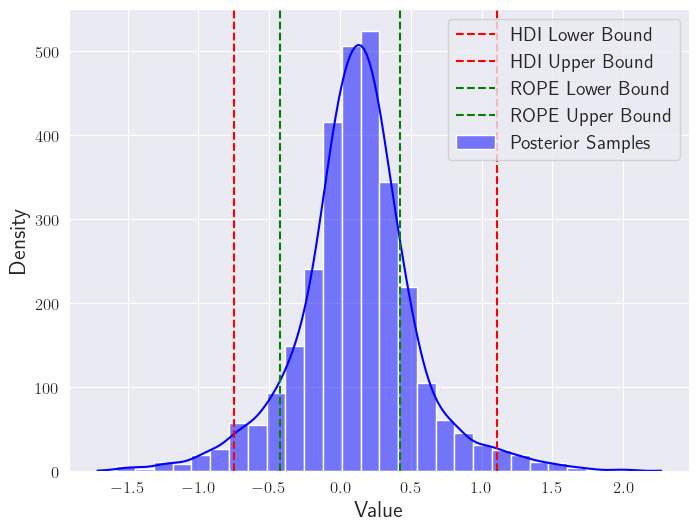

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.8793
--------- Predictor 11 ---------
--------- Predictor home_yes ---------
beta_home_yes_env_0 HDI: [-0.6303, 0.0887]
beta_home_yes_env_0 ROPE: [-0.0184, 0.0184]


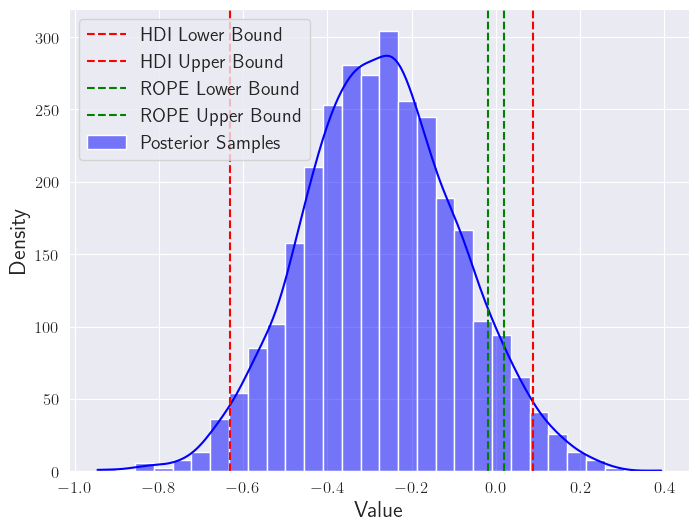

beta_home_yes_env_1 HDI: [-0.4126, 0.6834]
beta_home_yes_env_1 ROPE: [-0.0289, 0.0289]


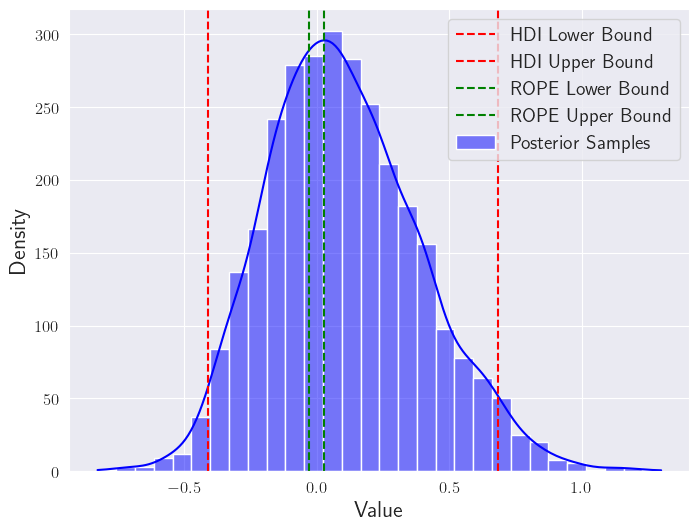

mu_home_yes HDI: [-0.9442, 1.0381]
mu_home_yes ROPE: [-0.4591, 0.4591]


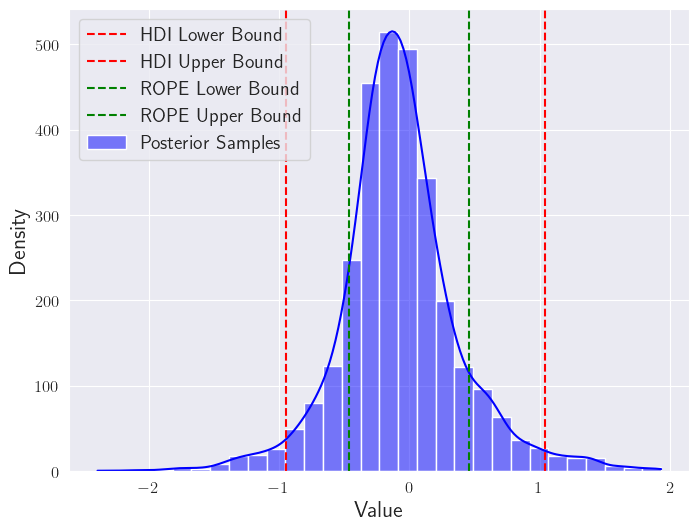

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.8439
--------- Predictor 12 ---------
--------- Predictor urban_yes ---------
beta_urban_yes_env_0 HDI: [-0.5031, 0.1373]
beta_urban_yes_env_0 ROPE: [-0.0164, 0.0164]


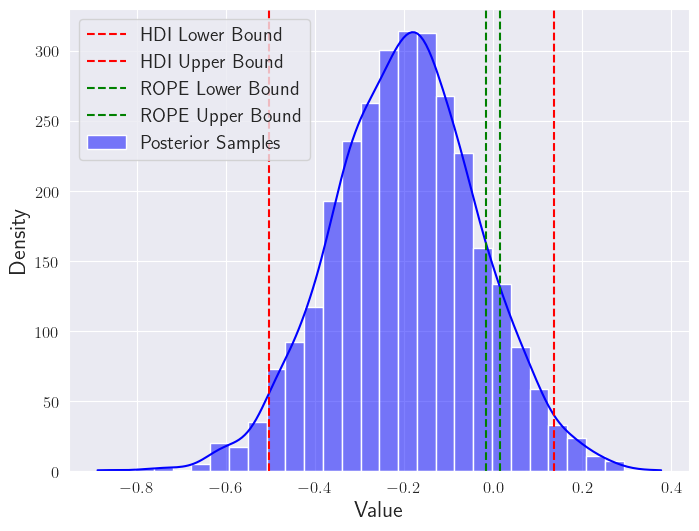

beta_urban_yes_env_1 HDI: [-1.0712, 0.2720]
beta_urban_yes_env_1 ROPE: [-0.0348, 0.0348]


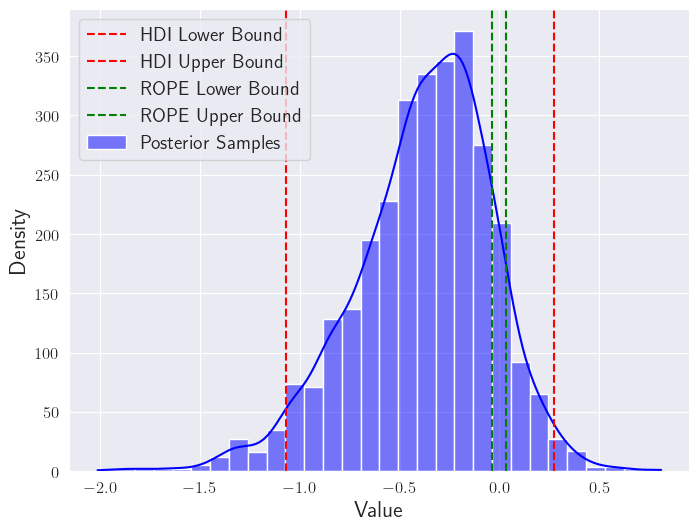

mu_urban_yes HDI: [-1.0466, 0.6382]
mu_urban_yes ROPE: [-0.4079, 0.4079]


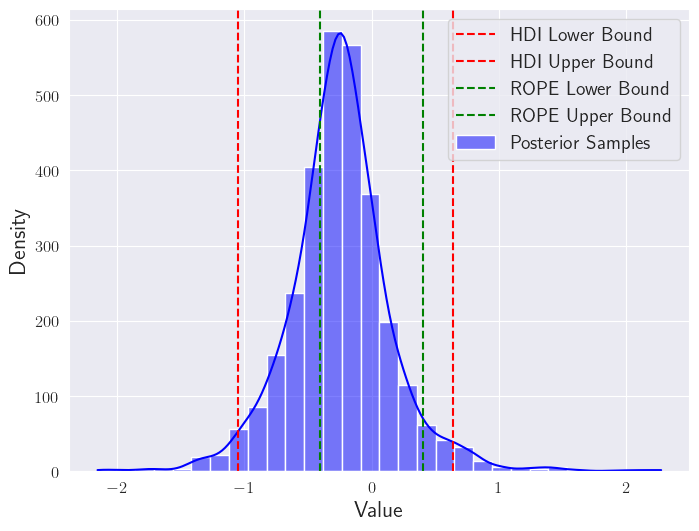

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9512
--------- Predictor 13 ---------
--------- Predictor income_low ---------
beta_income_low_env_0 HDI: [-0.7815, -0.2100]
beta_income_low_env_0 ROPE: [-0.0148, 0.0148]


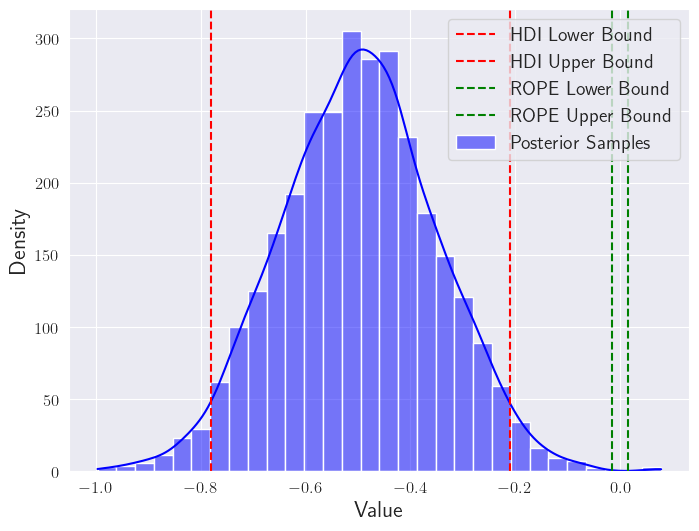

beta_income_low_env_1 HDI: [-0.8908, -0.1681]
beta_income_low_env_1 ROPE: [-0.0185, 0.0185]


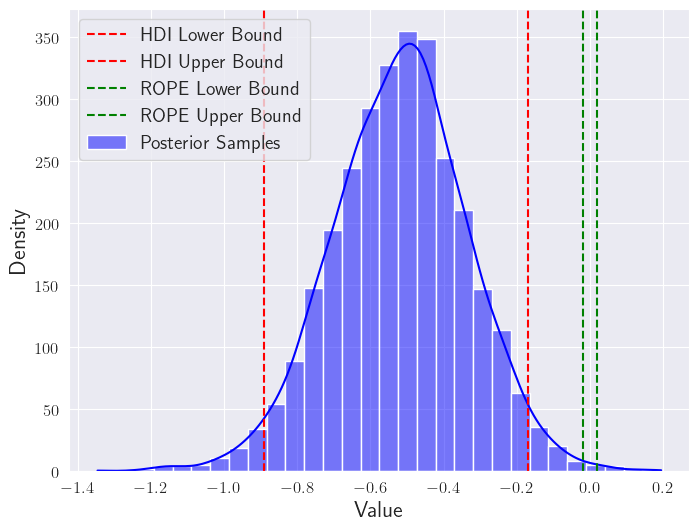

mu_income_low HDI: [-1.2540, 0.3109]
mu_income_low ROPE: [-0.3749, 0.3749]


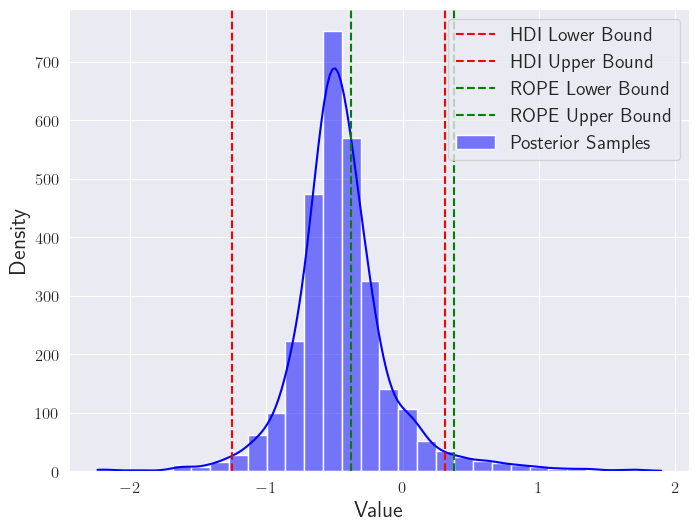

Local tests: ['Rejected', 'Rejected']
Global test for mu: Undecided
Pooling Factor (normal): 0.9992
--------- Predictor 14 ---------
--------- Predictor region_west ---------
beta_region_west_env_0 HDI: [-1.2732, -0.3009]
beta_region_west_env_0 ROPE: [-0.0247, 0.0247]


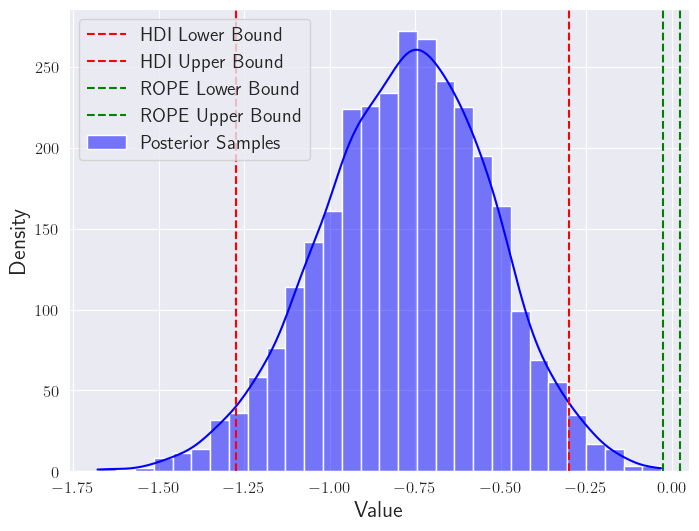

beta_region_west_env_1 HDI: [-1.1258, -0.0027]
beta_region_west_env_1 ROPE: [-0.0287, 0.0287]


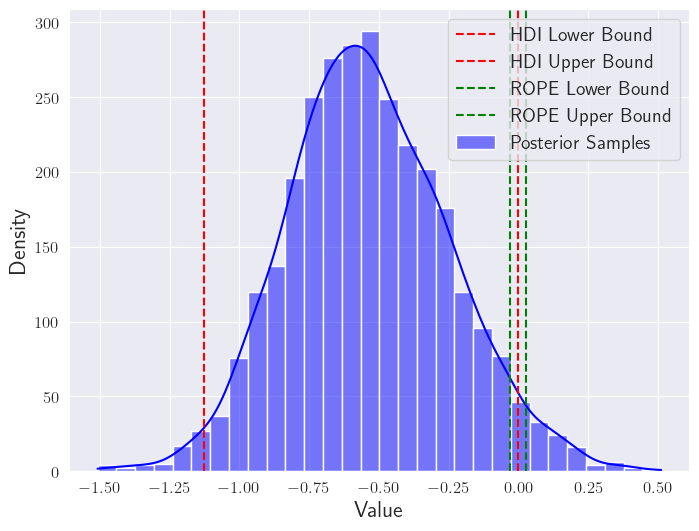

mu_region_west HDI: [-1.3594, 0.5066]
mu_region_west ROPE: [-0.4589, 0.4589]


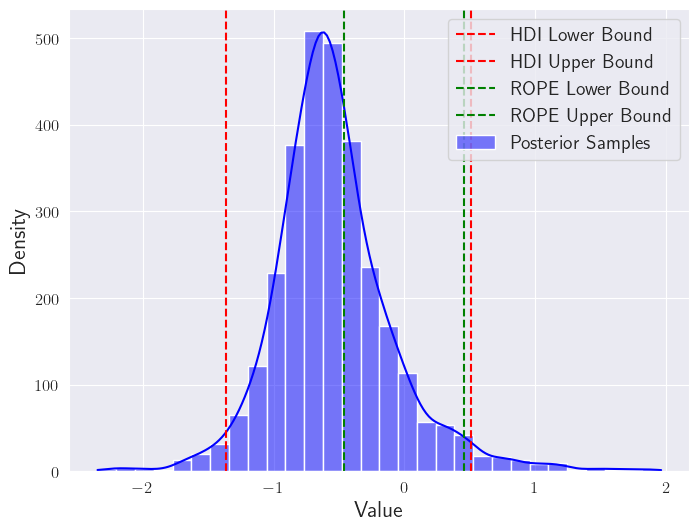

Local tests: ['Rejected', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9322
CONCLUSION
Predictors with significant mu (mu_pass): []
Predictors with significant beta in all environments (beta_pass): [0, 3, 13]
Predictors with high pooling factor (pool_pass): [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]


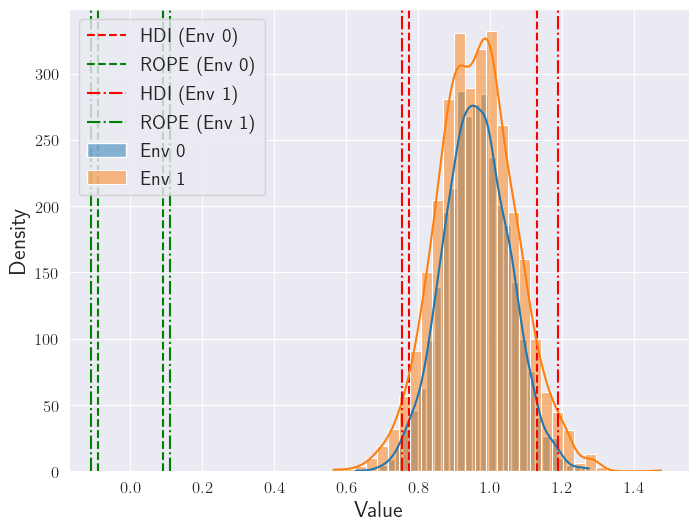

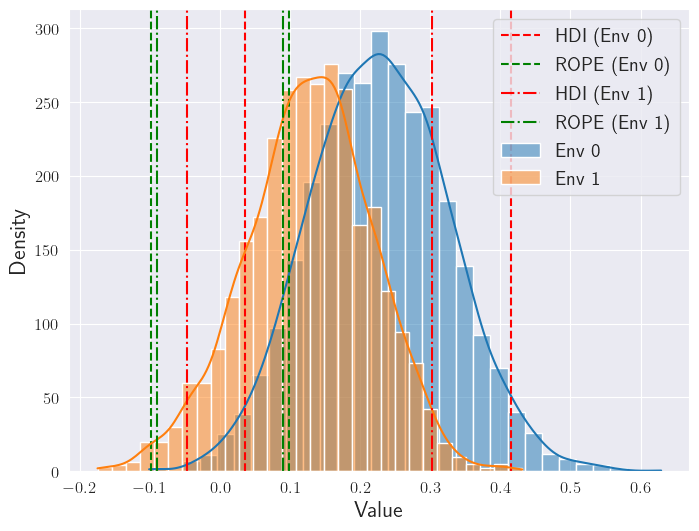

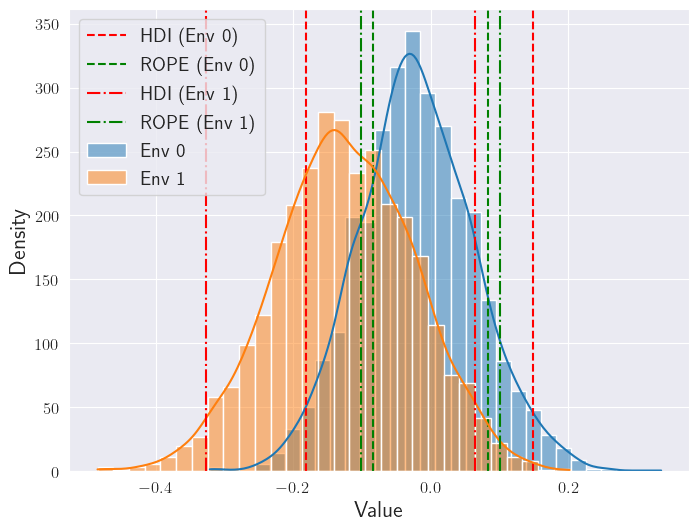

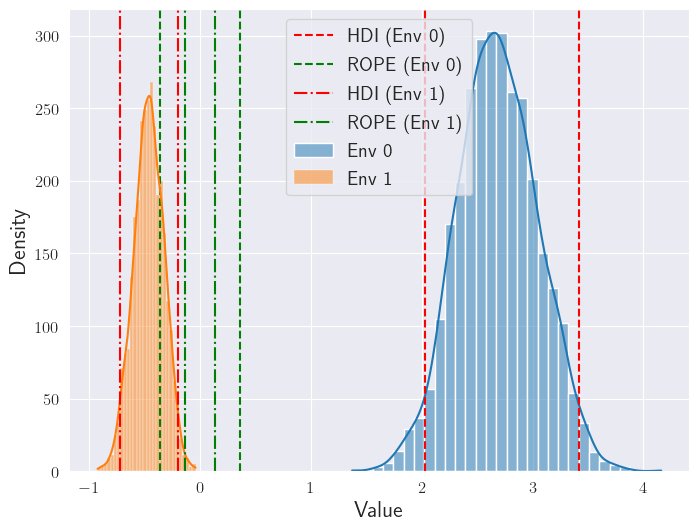

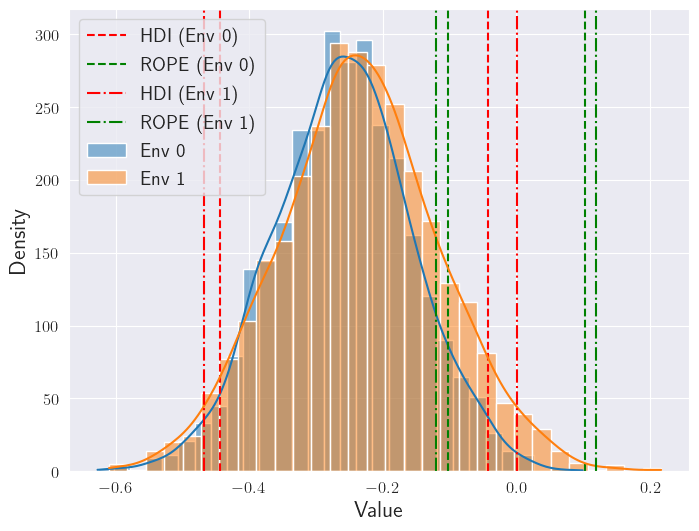

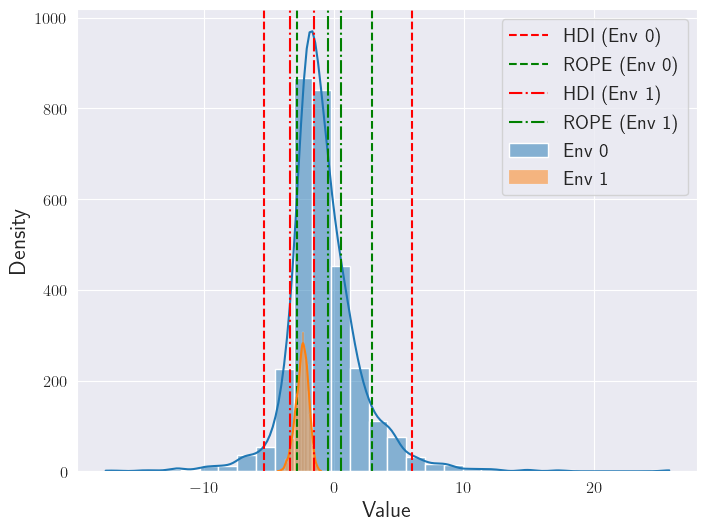

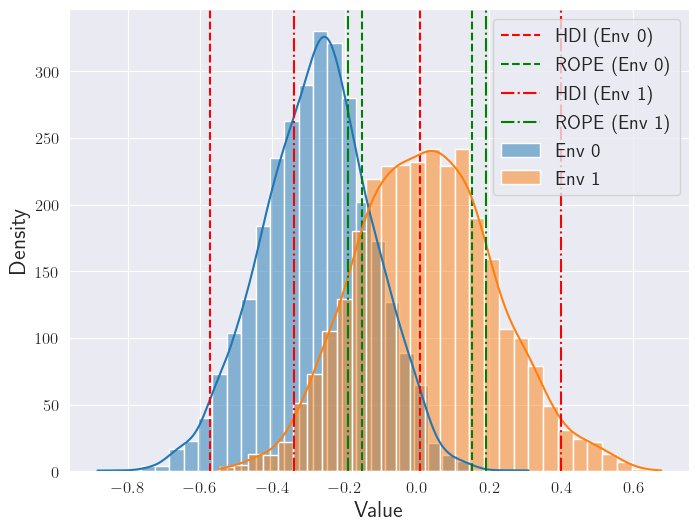

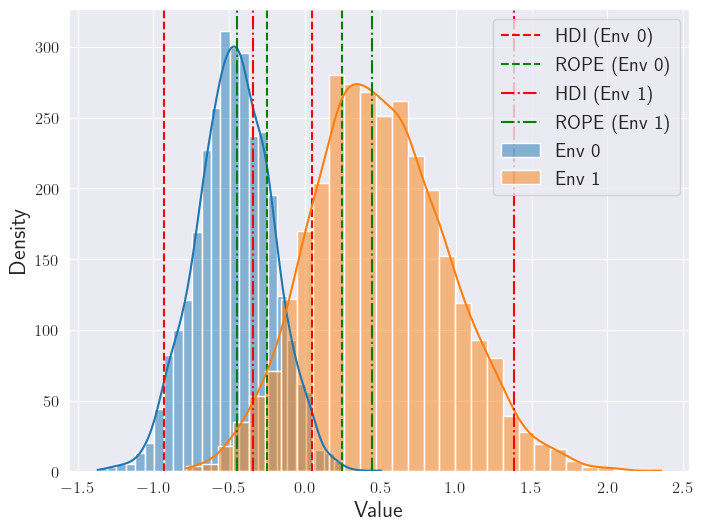

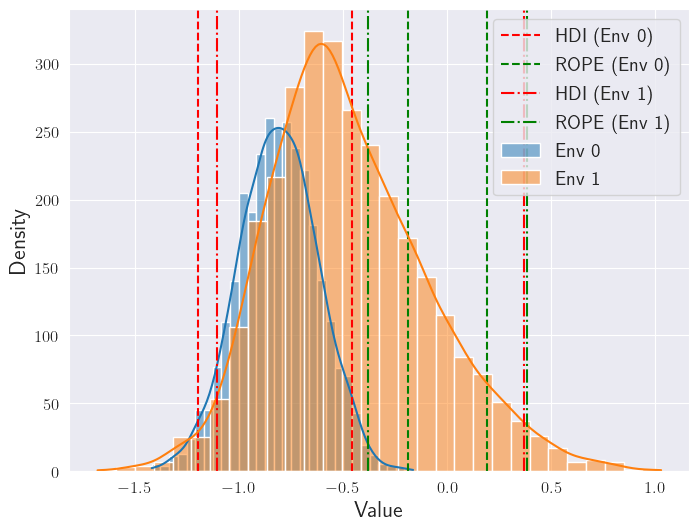

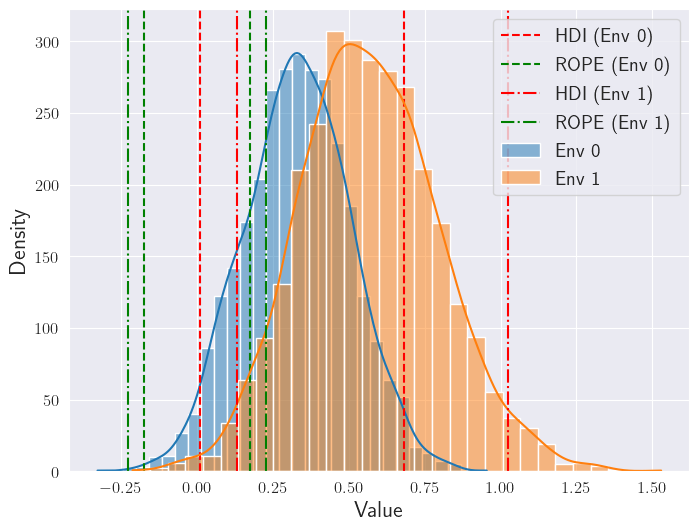

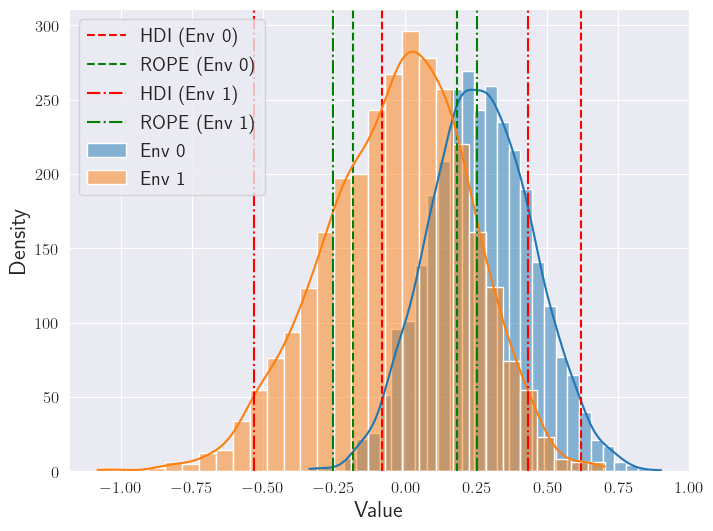

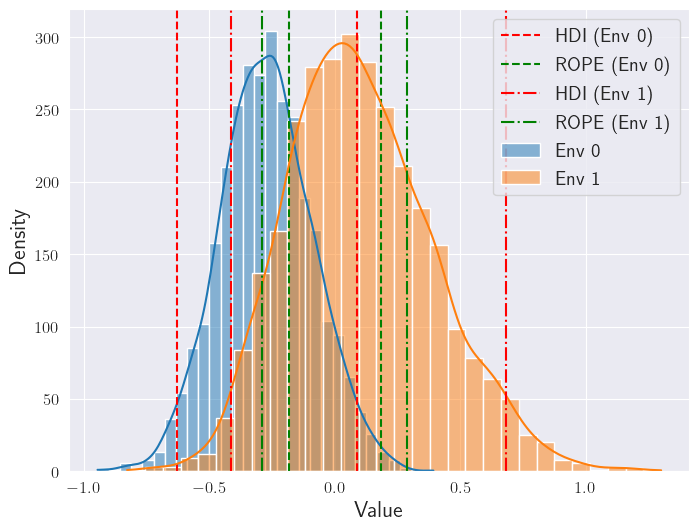

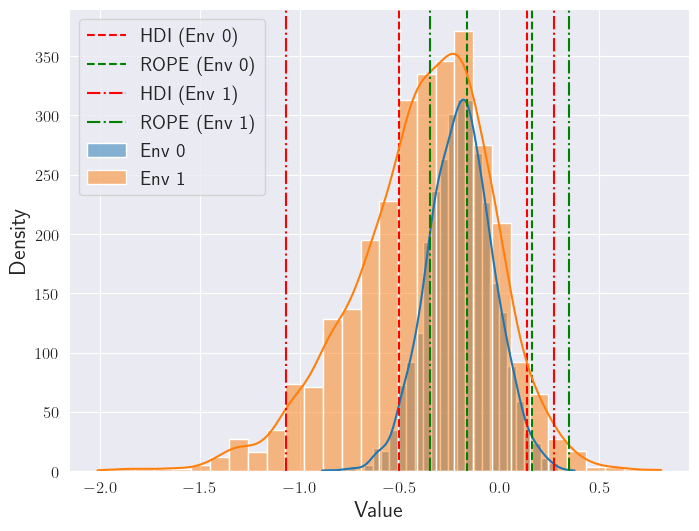

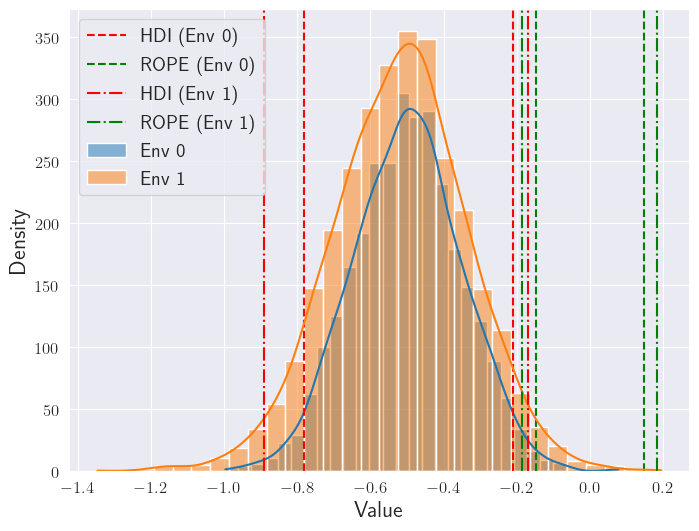

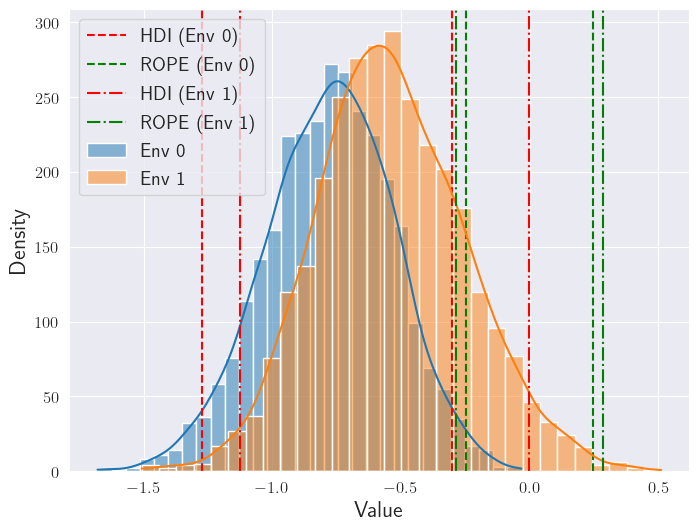

In [6]:
nuts_kernel = NUTS(nc_hierarchical_model_general)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=3000, num_chains=1)
mcmc.run(random.PRNGKey(42), N=X_jax.shape[0], D=X_jax.shape[1],
         E=E, e=e_jax, X=X_jax, y=Y_jax, model_func=hierarchical_logistic_model)
posterior_samples = mcmc.get_samples()

invariance_results = invariance_tests(
    posterior_samples,
    D=X_jax.shape[1],
    E=E,
    global_rope="tenth_sd",
    local_rope="tenth_sd",
    printing=True,
    X_cols=X_cols
)

In [7]:
mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta_decentered[0,0]      0.12      0.76      0.16     -1.21      1.30   2260.42      1.00
 beta_decentered[0,1]      0.25      0.78      0.24     -1.07      1.49   2106.98      1.00
 beta_decentered[0,2]      0.20      0.78      0.19     -1.04      1.53   2160.71      1.00
 beta_decentered[0,3]      1.20      0.61      1.14      0.27      2.18   2473.27      1.00
 beta_decentered[0,4]     -0.09      0.75     -0.08     -1.25      1.22   2293.25      1.00
 beta_decentered[0,5]      0.02      1.00      0.01     -1.64      1.61   4148.21      1.00
 beta_decentered[0,6]     -0.39      0.79     -0.36     -1.80      0.76   2537.15      1.00
 beta_decentered[0,7]     -0.62      0.71     -0.56     -1.80      0.52   2160.50      1.00
 beta_decentered[0,8]     -0.43      0.82     -0.45     -1.75      0.96   2209.34      1.00
 beta_decentered[0,9]     -0.21      0.80     -0.16     -1.60      1.04   1847.